In [1]:
# import libraries
import pandas as pd
import os
import spacy
from spacy.pipeline import EntityRuler
from spacy.displacy import render,serve
from IPython.core.display import display, HTML
from spacy.tokens import Span
from spacy.displacy import render,serve
import networkx as nx
import itertools
import json
import pylab
from spacy.util import filter_spans
import re
import tensorflow as tf
from transformers import *
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import spacy
from spacy import displacy
from keras.models import Model
from keras.layers import Input, LSTM, Lambda, Dense, Concatenate
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# for base model
# load libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
nltk.download('wordnet')
import numpy as np
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sye\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def bow_col2feat(train_data,test_data,column,paradict,bow=True):
    features_train, features_test,vectorizer = bag_of_word(train_data[column].apply(lambda x: " ".join(x)),
                                                            test_data[column].apply(lambda x: " ".join(x)),
                                                            paradict,bow=bow)
    return features_train, features_test,vectorizer

def bow_train_feature_stack(train_data,test_data,paradict,column_list,bow=True):
    features_stack_train = None
    features_stack_test = None
    for column in column_list:
        features_train,features_test,_ = bow_col2feat(train_data,test_data,column,paradict,bow=bow)
        features_stack_train = hstack((features_stack_train, features_train))
        features_stack_test = hstack((features_stack_test,features_test))
    return features_stack_train, features_stack_test

def bag_of_word(train,test,paradict,bow=True):
    vectorizer = CountVectorizer(ngram_range=paradict["NGRAM_RANGE"],
                                 max_features=paradict["MAX_FEATURES"],
                                 binary=paradict["BINARY"],
                                 max_df=paradict["MAX_DF"])
    if bow==False:
        vectorizer = TfidfVectorizer(ngram_range=paradict["NGRAM_RANGE"],
                                 max_features=paradict["MAX_FEATURES"],
                                 binary=paradict["BINARY"],
                                 max_df=paradict["MAX_DF"])
    train_data_features = vectorizer.fit_transform(train)
    test_data_features = vectorizer.transform(test)
    return train_data_features, test_data_features, vectorizer

bow_paradict = {
"NGRAM_RANGE":(1,3),
"MAX_FEATURES": 30,
"BINARY": False,
"MAX_DF":0.95}

In [4]:
from BertMerger import BadTERMMerger

In [5]:
LABELED_DATA = r"C:\Users\sye\OneDrive - MHP\Masterthese\data\processed_data\TW\labeled"

In [6]:
nlp = spacy.load(r"C:\Users\sye\OneDrive - MHP\Masterthese\py\ner\parameter")
nlp.add_pipe(nlp.create_pipe('merge_entities'))
term_merger = BadTERMMerger(nlp)
nlp.add_pipe(term_merger, before="ner")
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x1d33ba26f98>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x1d33bb45a08>),
 ('BadTERMMerger', <BertMerger.BadTERMMerger at 0x1d33b888550>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x1d33bb45a68>),
 ('merge_entities', <function spacy.pipeline.functions.merge_entities(doc)>)]

In [7]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 1000)

In [8]:
def return_quant_token(row):
    q_t = None
    i = None
    text_doc = nlp(row["Text"])
    for t in text_doc:
        if row["Quant"].strip().lower() in t.text.lower():
            q_t = t
            i = t.i
    return q_t, i

def return_target_token(row):
    t_t = None
    i = None
    text_doc = nlp(row["Text"])
    for t in text_doc:
        if str(row["target"]).strip().lower() in t.text.lower():
            t_t = t
            i = t.i
    return t_t, i

def sent_snippet(row):
    span = None
    if (row["Quant_Token"][1] is not None) and (row["target_Token"][1] is not None):
        start = min(row["Quant_Token"][1],row["target_Token"][1])
        end = max(row["Quant_Token"][1],row["target_Token"][1])
        span = row["Tokens"][start:end+1]
    return span
        

In [9]:
def read_labeled_data(data_path):
    gesamt = pd.DataFrame()
    for path, _, files in os.walk(data_path):
        for FILE_NAME in tqdm(files):
            try:
                test_input = pd.read_excel(os.path.join(path, FILE_NAME),usecols = ["Text","Quant","Target","Label"],dtype={"Text":str,"Quant": str,"Target":str})
                test_input.dropna(subset=["Label"], inplace=True,axis=0)
                test_input = test_input.reset_index(drop=True)
                test_input.rename(columns={"Target":"target","Label":"label"}, inplace=True)
                test_input["label"] = test_input["label"].apply(lambda x: int(x))
                test_input["Tokens"] = test_input.Text.apply(lambda x: [t for t in nlp(x)])
                test_input["Quant_Token"] = test_input.apply(return_quant_token, axis=1)
                test_input["target_Token"] = test_input.apply(return_target_token, axis=1)
                test_input["Sent_Span"] = test_input.apply(sent_snippet, axis=1)
                valided_index = []
                for row in range(len(test_input)):
                    tokens = test_input.loc[row, "Tokens"]
                    quant_index= test_input.loc[row, "Quant_Token"][1]
                    target_index = test_input.loc[row, "target_Token"][1]
                    if quant_index is not None:
                        if tokens[quant_index].head==tokens[target_index].head:
                            valided_index.append(row)
                cleaned = test_input.loc[valided_index,:]
                cleaned =test_input.reset_index(drop=True)
                print(FILE_NAME)
                gesamt = gesamt.append(cleaned,ignore_index=True)
            except:
                print("ERROR!:",FILE_NAME)
                continue
    return gesamt

In [10]:
train_data = read_labeled_data(data_path=LABELED_DATA)

  0%|                                                                                           | 0/59 [00:00<?, ?it/s]

01 The applicable motor vehicle category for vehicle inspection and testing.pdf.xlsx


  2%|█▍                                                                                 | 1/59 [00:00<00:27,  2.10it/s]

02 The requirement of specification for motor vehicle.xlsx


  3%|██▊                                                                                | 2/59 [00:10<03:08,  3.30s/it]

03-0 The installation of lighting and light-signaling devices.xlsx


  5%|████▏                                                                              | 3/59 [00:10<02:15,  2.43s/it]

03-1 The installation of lighting and light-signaling devices.xlsx


  7%|█████▋                                                                             | 4/59 [00:15<02:55,  3.19s/it]

04 Static Braking.xlsx


  8%|███████                                                                            | 5/59 [00:15<02:04,  2.30s/it]

06 The inspection requirement of fuel system for CNG vehicle.xlsx


 10%|████████▍                                                                          | 6/59 [00:16<01:34,  1.79s/it]

07 The lateral protection device and the Rear Underrun Protection Device (RUPD)(or bumper).xlsx


 12%|█████████▊                                                                         | 7/59 [00:17<01:18,  1.50s/it]

08 The requirement of vehicle tilt stability.xlsx


 14%|███████████▎                                                                       | 8/59 [00:17<00:56,  1.11s/it]

09-2 Installation of audible warning devices.xlsx


 15%|████████████▋                                                                      | 9/59 [00:17<00:40,  1.23it/s]

10 Installation requirements of pay load meter.xlsx
11 The installation requirement of turning and reversing audible warning device.xlsx


 19%|███████████████▎                                                                  | 11/59 [00:17<00:28,  1.71it/s]

12 The thermal-insulation protection device of exhaust system for motorcycle.xlsx
13 The requirement of stability and durability regarding motorcycle stands.xlsx


 22%|██████████████████                                                                | 13/59 [00:17<00:19,  2.35it/s]

15 Payload meter.xlsx
19 Flammability of the interior materials for motor vehicle.xlsx


 25%|████████████████████▊                                                             | 15/59 [00:18<00:14,  3.05it/s]

19-1 Flammability of the interior materials for motor vehicle.xlsx
21-1 Audible warning devices.xlsx


 29%|███████████████████████▋                                                          | 17/59 [00:19<00:17,  2.44it/s]

22 Speedometer.xlsx


 31%|█████████████████████████                                                         | 18/59 [00:19<00:15,  2.71it/s]

23-2 Installation of devices for indirect vision.xlsx


 32%|██████████████████████████▍                                                       | 19/59 [00:20<00:26,  1.53it/s]

24 Driver operated controls.pdf.xlsx


 34%|███████████████████████████▊                                                      | 20/59 [00:21<00:19,  1.96it/s]

25-3 Safety Glass.xlsx


 36%|█████████████████████████████▏                                                    | 21/59 [00:24<00:47,  1.24s/it]

26-1 Safety Belt.xlsx


 37%|██████████████████████████████▌                                                   | 22/59 [00:25<00:47,  1.29s/it]

27 Devices for indirect vision.xlsx


 39%|███████████████████████████████▉                                                  | 23/59 [00:26<00:42,  1.18s/it]

29 Filament lamps.pdf.xlsx


 41%|█████████████████████████████████▎                                                | 24/59 [00:26<00:34,  1.00it/s]

31 Direction indicator.xlsx


 42%|██████████████████████████████████▋                                               | 25/59 [00:28<00:36,  1.09s/it]

33 Reversing lamps.xlsx


 44%|████████████████████████████████████▏                                             | 26/59 [00:28<00:27,  1.21it/s]

34 Front position lamps.xlsx


 46%|█████████████████████████████████████▌                                            | 27/59 [00:28<00:22,  1.39it/s]

35 Rear position lamps.xlsx


 47%|██████████████████████████████████████▉                                           | 28/59 [00:29<00:18,  1.68it/s]

39 End-outline marker lamp.xlsx


 49%|████████████████████████████████████████▎                                         | 29/59 [00:29<00:14,  2.03it/s]

41-0 Reflex reflectors.xlsx


 51%|█████████████████████████████████████████▋                                        | 30/59 [00:29<00:13,  2.17it/s]

42-3 Dynamic Braking.xlsx


 53%|███████████████████████████████████████████                                       | 31/59 [00:31<00:23,  1.19it/s]

44-1 Steering control system.xlsx
48-2 Safety belt anchorage.xlsx


 56%|█████████████████████████████████████████████▊                                    | 33/59 [00:31<00:16,  1.56it/s]

49-1 Seats.xlsx
50 Head restraint.xlsx


 59%|████████████████████████████████████████████████▋                                 | 35/59 [00:32<00:11,  2.02it/s]

51-2 Door latches and retention components.xlsx
52-2 Headlamps (headlamps of gas-discharge type excluded).xlsx


 63%|███████████████████████████████████████████████████▍                              | 37/59 [00:32<00:08,  2.50it/s]

54-3 Prevention of fire risks for large passenger vehicle.xlsx


 64%|████████████████████████████████████████████████████▊                             | 38/59 [00:32<00:07,  2.90it/s]

55 Strength of super structure for large passenger vehicle.xlsx


 66%|██████████████████████████████████████████████████████▏                           | 39/59 [00:32<00:05,  3.64it/s]

56-3 Electromagnetic Compatibility.pdf.xlsx


 68%|███████████████████████████████████████████████████████▌                          | 40/59 [00:33<00:05,  3.27it/s]

58 The frameíªs fatigue strength of small-light moped.pdf.xlsx
59-1 Adaptive front lighting system (AFS).pdf.xlsx


 71%|██████████████████████████████████████████████████████████▎                       | 42/59 [00:33<00:04,  4.04it/s]

61 The installation of the mechanical coupling device or component.pdf.xlsx
62 Mechanical coupling device or component.pdf.xlsx


 75%|█████████████████████████████████████████████████████████████▏                    | 44/59 [00:33<00:03,  4.47it/s]

63-1 Low floor vehicle.pdf.xlsx


 76%|██████████████████████████████████████████████████████████████▌                   | 45/59 [00:34<00:03,  3.62it/s]

66 fuel tank.pdf.xlsx


 78%|███████████████████████████████████████████████████████████████▉                  | 46/59 [00:34<00:02,  4.46it/s]

70 Lane departure warning system.pdf.xlsx
72 Advanced emergency braking system.pdf.xlsx


 81%|██████████████████████████████████████████████████████████████████▋               | 48/59 [00:34<00:02,  5.42it/s]

73 Daytime running lamp.xlsx
74 LED light sources.pdf.xlsx


 85%|█████████████████████████████████████████████████████████████████████▍            | 50/59 [00:34<00:01,  6.82it/s]

76 Speed limitation devices.pdf.xlsx
77 External projections.pdf.xlsx


 88%|████████████████████████████████████████████████████████████████████████▎         | 52/59 [00:35<00:01,  5.42it/s]

78 External projections (commercial vehicle).pdf.xlsx


 90%|█████████████████████████████████████████████████████████████████████████▋        | 53/59 [00:35<00:01,  4.19it/s]

79 Rear marking plates for heavy and long vehicles.pdf.xlsx
83 Specifications of specific components for the compressed hydrogen storage system.pdf.xlsx


 93%|████████████████████████████████████████████████████████████████████████████▍     | 55/59 [00:35<00:00,  5.03it/s]

84 Brake assist systems.pdf.xlsx
86 Rear-end collision for prevention of fuel tank fire risks.pdf.xlsx


 97%|███████████████████████████████████████████████████████████████████████████████▏  | 57/59 [00:35<00:00,  6.08it/s]

89 Specifications of the compressed hydrogen storage system(L).pdf.xlsx
90 Specifications of specific components for the compressed hydrogen storage system(L).pdf.xlsx


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:36<00:00,  7.07it/s]


In [11]:
len(train_data)

1129

In [12]:
tokenized_df = train_data

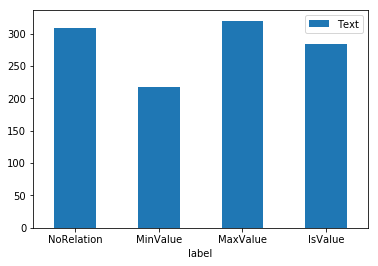

In [13]:
count = tokenized_df.groupby(by="label").count().reset_index()
num2label = {0: "NoRelation",
             1: "MinValue",
             2: "MaxValue",
             3: "IsValue"}
count["label"] = count["label"].apply(lambda x: num2label[x])
bar = count.plot(kind="bar",x="label", y="Text",rot=0)


In [14]:
doc = nlp("The mean wind speed measured at a height of at least 1 m above the ground shall be less than 6 m/s with gusts not exceeding 10 m/s.")

In [15]:
displacy.render(doc,style='ent')

In [16]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
#bert_model = BertModel.from_pretrained("bert-base-cased")

In [17]:
def bert_token_pre(dataframe, index, output = "all"):
    """
    output: "all"- output whole sentence
    output: "sub" - output separately 
    """
    end = max(dataframe.loc[index, "Quant_Token"][1],dataframe.loc[index, "target_Token"][1])
    start = min(dataframe.loc[index, "Quant_Token"][1],dataframe.loc[index, "target_Token"][1])
    span_before = " ".join([t.text for t in dataframe.loc[index,"Tokens"][:start-1]])
    span_current = " ".join([t.text for t in dataframe.loc[index, "Tokens"][start:end+1]])
    span_after = " ".join([t.text for t in dataframe.loc[index, "Tokens"][end+1:]])
    ber_tok_before = tokenizer.tokenize(span_before)
    ber_tok_span = tokenizer.tokenize(span_current)
    ber_tok_after = tokenizer.tokenize(span_after)
    ber_tok_all = ber_tok_before + ber_tok_span + ber_tok_after
    if output == "all":
        return ber_tok_all
    elif output == "sub":
        return ber_tok_before, ber_tok_span, ber_tok_after

In [18]:
# well let's first get out all the bert embedding
tokenized_df_bert = tokenized_df[tokenized_df.Sent_Span!=None]
tokenized_df_bert = tokenized_df_bert[tokenized_df_bert.Quant_Token != (None,None)]
tokenized_df_bert = tokenized_df_bert[tokenized_df_bert.target_Token!=(None,None)]
tokenized_df_bert = tokenized_df_bert.reset_index(drop=True)

In [19]:
len(tokenized_df_bert)

1129

In [20]:
MAXTEXTSPAN=max(tokenized_df_bert["Sent_Span"].apply(lambda x: len(x)))

In [21]:
#tokenizer.encode_plus(tokenized_df.loc[0,"Text"],)
def padding(tokenized_list, max_length):
    if len(tokenized_list) < max_length:
        tokens = ["[CLS]"] + tokenized_list + ["[SEP]"] + (max_length - len(tokenized_list))*["[PAD]"]
    else:
        tokens = ["[CLS]"] + tokenized_list + ["[SEP]"]
    return tokens
    

In [22]:
# 1. add [CLS] [SEP] tokens
def output_maxlen(dataframe):
    maxlen = 0
    maxlen = max([len(tokenizer.tokenize(text)) for text in dataframe["Text"]])
    return maxlen
MAX_LEN = output_maxlen(tokenized_df)
MAX_LEN

201

In [23]:
model = BertModel.from_pretrained("bert-base-cased")

In [41]:
# prepare for input_id
def get_hidden_state(dataframe):
    input_ids = []
    attention_masks = []
    for index in range(len(dataframe)):
        tokenized_list = bert_token_pre(dataframe, index, output = "all")
        padded = padding(tokenized_list, output_maxlen(dataframe))
        attention_mask = [1 if t!="[PAD]" else 0 for t in padded]
        encoded = tokenizer.encode_plus(padded, add_special_tokens=False, pad_to_max_length=True,
                                       is_pretokenized = True, return_tensors="pt")
        input_id = encoded["input_ids"]
        input_ids.append(input_id)
        attention_masks.append(torch.tensor(attention_mask))
    print(len(input_ids))
    print(len(attention_masks))
    input_ids = torch.cat(input_ids, dim=0)
    ats = torch.cat(attention_masks, dim=0)

    with torch.no_grad():
        last_hidden_states = model(input_ids=input_ids)[0].numpy()
    return last_hidden_states
        

In [25]:
def generate_train_data(train_df, last_hidden_states_np):
    length_bert_tokens = []
    lstm_inputs = []
    for i in range(len(train_df)):
        bf, span, after = bert_token_pre(train_df, i, output = "sub")
        all_bert_tokens = bert_token_pre(train_df, i, output = "all")
        bert_index = (len(bf),len(after))
        #print(bert_index)
        length_bert_tokens.append(len(all_bert_tokens[len(bf):len(bf)+len(span)]))
        bert_span_start = len(bf)+1
        bert_span_end = len(bf)+len(span)
        hidden_state = last_hidden_states_np[i,len(bf):len(bf)+len(span),:]
        lstm_inputs.append(hidden_state)
    padded = pad_sequences(lstm_inputs, maxlen=MAXTEXTSPAN, padding='post')
    return padded
    

In [26]:
num_classes = len(set(tokenized_df_bert["label"]))

In [27]:
SEN_LEN = MAXTEXTSPAN
DIM = 768

In [28]:
SEN_LEN

52

In [29]:
Bert_input = Input(shape=(SEN_LEN,DIM))
X, X_lstm1, _ = LSTM(768, dropout=0.3, return_state=True, return_sequences=True)(Bert_input)
X, X_lstm2, _ = LSTM(768, dropout=0.3, go_backwards=True, return_state=True)(X)
X = Concatenate()([X_lstm1,X_lstm2])
X= Dense(4, activation="softmax")(X)

general_model = Model(Bert_input,X, name="bertforRX")
general_model.summary()

Model: "bertforRX"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 52, 768)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 52, 768), (N 4721664     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 768), (None, 4721664     lstm_1[0][0]                     
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1536)         0           lstm_1[0][1]                     
                                                                 lstm_2[0][1]             

In [30]:
from keras.optimizers import Adam
general_model.compile(Adam(5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
num2label = {0:"NoRelation",
             1:"MinValue",
             2: "MaxValue",
             3: "IsValue"}

In [32]:
X_train, X_test, y_train, y_test = train_test_split(tokenized_df_bert.loc[:,~tokenized_df_bert.columns.isin(["label"])], tokenized_df_bert["label"], test_size=0.2, random_state=42)

## base model

In [33]:
X_train["span"] = X_train["Sent_Span"].apply(lambda x: [k.text for k in x])
X_test["span"] = X_test["Sent_Span"].apply(lambda x:[k.text for k in x])
X_train["pos"] = X_train["Sent_Span"].apply(lambda x: [k.pos_ for k in x])
X_test["pos"] = X_test["Sent_Span"].apply(lambda x: [k.pos_ for k in x])
X_train["dep"] = X_train["Sent_Span"].apply(lambda x: [k.dep_ for k in x])
X_test["dep"] = X_test["Sent_Span"].apply(lambda x: [k.dep_ for k in x])

In [34]:
for df in [X_train, X_test, y_train, y_test]:
    df.reset_index(drop=True, inplace=True)

In [35]:
features_stack_train, features_stack_test = bow_train_feature_stack(X_train, X_test, bow_paradict,
                                                                    ["span","pos", "dep"],bow=False)



In [36]:
lr = LogisticRegression(random_state=45,solver="lbfgs").fit(features_stack_train,y_train)
y_pred=lr.predict(features_stack_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

C:\Users\sye\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[[40  5  5  8]
 [ 4 27  9  0]
 [ 2  7 53  0]
 [17  1  0 48]]
              precision    recall  f1-score   support

           0       0.63      0.69      0.66        58
           1       0.68      0.68      0.68        40
           2       0.79      0.85      0.82        62
           3       0.86      0.73      0.79        66

   micro avg       0.74      0.74      0.74       226
   macro avg       0.74      0.74      0.74       226
weighted avg       0.75      0.74      0.74       226

0.7433628318584071


In [37]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(features_stack_train,y_train)
y_pred = svclassifier.predict(features_stack_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[43  5  5  5]
 [ 3 28  9  0]
 [ 2  7 53  0]
 [14  1  1 50]]
              precision    recall  f1-score   support

           0       0.69      0.74      0.72        58
           1       0.68      0.70      0.69        40
           2       0.78      0.85      0.82        62
           3       0.91      0.76      0.83        66

   micro avg       0.77      0.77      0.77       226
   macro avg       0.77      0.76      0.76       226
weighted avg       0.78      0.77      0.77       226

0.7699115044247787


## end of base model

In [42]:
# prepare train and test data
train_last_hidden_states_np = get_hidden_state(X_train)
X_train_input = generate_train_data(X_train, train_last_hidden_states_np)
test_last_hidden_states_np = get_hidden_state(X_test)
X_test_input = generate_train_data(X_test, test_last_hidden_states_np)

903
903
226
226


In [43]:
X_train_input.shape

(903, 52, 768)

In [44]:
epochs = 100
batch_size = 32

history = general_model.fit(x=X_train_input,
                  y=to_categorical(y_train),batch_size = batch_size,validation_data=(X_test_input,to_categorical(y_test)),
                  epochs = epochs)

Train on 903 samples, validate on 226 samples
Epoch 1/100
903/903 [==============================] - ETA: 1:15 - loss: 1.3654 - accuracy: 0.37 - ETA: 1:01 - loss: 1.3797 - accuracy: 0.31 - ETA: 56s - loss: 1.3832 - accuracy: 0.2917 - ETA: 53s - loss: 1.3896 - accuracy: 0.289 - ETA: 49s - loss: 1.3869 - accuracy: 0.287 - ETA: 47s - loss: 1.3845 - accuracy: 0.296 - ETA: 44s - loss: 1.3814 - accuracy: 0.312 - ETA: 42s - loss: 1.3827 - accuracy: 0.312 - ETA: 39s - loss: 1.3782 - accuracy: 0.333 - ETA: 37s - loss: 1.3754 - accuracy: 0.334 - ETA: 35s - loss: 1.3763 - accuracy: 0.329 - ETA: 33s - loss: 1.3741 - accuracy: 0.330 - ETA: 31s - loss: 1.3751 - accuracy: 0.322 - ETA: 28s - loss: 1.3770 - accuracy: 0.312 - ETA: 26s - loss: 1.3750 - accuracy: 0.316 - ETA: 24s - loss: 1.3738 - accuracy: 0.318 - ETA: 22s - loss: 1.3728 - accuracy: 0.321 - ETA: 20s - loss: 1.3712 - accuracy: 0.328 - ETA: 18s - loss: 1.3698 - accuracy: 0.335 - ETA: 16s - loss: 1.3666 - accuracy: 0.342 - ETA: 14s - loss: 1

Epoch 7/100
903/903 [==============================] - ETA: 56s - loss: 0.6206 - accuracy: 0.812 - ETA: 54s - loss: 0.6820 - accuracy: 0.734 - ETA: 52s - loss: 0.6129 - accuracy: 0.750 - ETA: 50s - loss: 0.6184 - accuracy: 0.757 - ETA: 48s - loss: 0.5862 - accuracy: 0.768 - ETA: 46s - loss: 0.5837 - accuracy: 0.760 - ETA: 44s - loss: 0.5955 - accuracy: 0.750 - ETA: 42s - loss: 0.5935 - accuracy: 0.746 - ETA: 40s - loss: 0.6197 - accuracy: 0.743 - ETA: 38s - loss: 0.6389 - accuracy: 0.731 - ETA: 36s - loss: 0.6495 - accuracy: 0.727 - ETA: 34s - loss: 0.6619 - accuracy: 0.726 - ETA: 32s - loss: 0.6598 - accuracy: 0.735 - ETA: 30s - loss: 0.6544 - accuracy: 0.743 - ETA: 27s - loss: 0.6506 - accuracy: 0.743 - ETA: 25s - loss: 0.6441 - accuracy: 0.748 - ETA: 23s - loss: 0.6427 - accuracy: 0.746 - ETA: 21s - loss: 0.6357 - accuracy: 0.748 - ETA: 19s - loss: 0.6345 - accuracy: 0.750 - ETA: 17s - loss: 0.6394 - accuracy: 0.748 - ETA: 15s - loss: 0.6387 - accuracy: 0.747 - ETA: 13s - loss: 0.63

Epoch 13/100
903/903 [==============================] - ETA: 1:01 - loss: 0.5044 - accuracy: 0.75 - ETA: 1:00 - loss: 0.3663 - accuracy: 0.84 - ETA: 59s - loss: 0.3599 - accuracy: 0.8542 - ETA: 57s - loss: 0.3749 - accuracy: 0.851 - ETA: 54s - loss: 0.3678 - accuracy: 0.856 - ETA: 52s - loss: 0.3856 - accuracy: 0.854 - ETA: 50s - loss: 0.3955 - accuracy: 0.848 - ETA: 47s - loss: 0.3912 - accuracy: 0.851 - ETA: 45s - loss: 0.4021 - accuracy: 0.843 - ETA: 43s - loss: 0.4053 - accuracy: 0.843 - ETA: 41s - loss: 0.4046 - accuracy: 0.843 - ETA: 38s - loss: 0.4033 - accuracy: 0.841 - ETA: 36s - loss: 0.4030 - accuracy: 0.846 - ETA: 34s - loss: 0.4007 - accuracy: 0.848 - ETA: 31s - loss: 0.3991 - accuracy: 0.852 - ETA: 29s - loss: 0.3917 - accuracy: 0.859 - ETA: 27s - loss: 0.3840 - accuracy: 0.864 - ETA: 24s - loss: 0.3868 - accuracy: 0.864 - ETA: 22s - loss: 0.3819 - accuracy: 0.868 - ETA: 20s - loss: 0.3707 - accuracy: 0.873 - ETA: 17s - loss: 0.3669 - accuracy: 0.875 - ETA: 15s - loss: 0.

Epoch 19/100
903/903 [==============================] - ETA: 1:02 - loss: 0.1629 - accuracy: 0.96 - ETA: 1:00 - loss: 0.1266 - accuracy: 0.98 - ETA: 1:00 - loss: 0.2098 - accuracy: 0.95 - ETA: 58s - loss: 0.2410 - accuracy: 0.9297 - ETA: 56s - loss: 0.2794 - accuracy: 0.906 - ETA: 54s - loss: 0.2623 - accuracy: 0.911 - ETA: 51s - loss: 0.3021 - accuracy: 0.892 - ETA: 49s - loss: 0.3059 - accuracy: 0.890 - ETA: 46s - loss: 0.2913 - accuracy: 0.899 - ETA: 44s - loss: 0.2846 - accuracy: 0.896 - ETA: 41s - loss: 0.2791 - accuracy: 0.900 - ETA: 39s - loss: 0.2770 - accuracy: 0.903 - ETA: 36s - loss: 0.2968 - accuracy: 0.901 - ETA: 34s - loss: 0.2941 - accuracy: 0.901 - ETA: 31s - loss: 0.2889 - accuracy: 0.904 - ETA: 29s - loss: 0.2966 - accuracy: 0.900 - ETA: 26s - loss: 0.2856 - accuracy: 0.904 - ETA: 24s - loss: 0.2754 - accuracy: 0.908 - ETA: 21s - loss: 0.2725 - accuracy: 0.907 - ETA: 19s - loss: 0.2804 - accuracy: 0.904 - ETA: 17s - loss: 0.2719 - accuracy: 0.907 - ETA: 14s - loss: 0.

Epoch 25/100
903/903 [==============================] - ETA: 1:03 - loss: 0.1662 - accuracy: 0.90 - ETA: 1:02 - loss: 0.1662 - accuracy: 0.92 - ETA: 1:01 - loss: 0.1701 - accuracy: 0.92 - ETA: 58s - loss: 0.1609 - accuracy: 0.9375 - ETA: 55s - loss: 0.1463 - accuracy: 0.943 - ETA: 53s - loss: 0.2081 - accuracy: 0.927 - ETA: 51s - loss: 0.2524 - accuracy: 0.919 - ETA: 48s - loss: 0.2478 - accuracy: 0.921 - ETA: 46s - loss: 0.2318 - accuracy: 0.930 - ETA: 43s - loss: 0.2276 - accuracy: 0.934 - ETA: 40s - loss: 0.2117 - accuracy: 0.940 - ETA: 38s - loss: 0.2134 - accuracy: 0.937 - ETA: 36s - loss: 0.2121 - accuracy: 0.935 - ETA: 33s - loss: 0.2069 - accuracy: 0.933 - ETA: 31s - loss: 0.2062 - accuracy: 0.933 - ETA: 28s - loss: 0.2139 - accuracy: 0.929 - ETA: 26s - loss: 0.2082 - accuracy: 0.930 - ETA: 24s - loss: 0.2066 - accuracy: 0.930 - ETA: 21s - loss: 0.2049 - accuracy: 0.930 - ETA: 19s - loss: 0.2098 - accuracy: 0.928 - ETA: 17s - loss: 0.2165 - accuracy: 0.925 - ETA: 14s - loss: 0.

Epoch 31/100
903/903 [==============================] - ETA: 1:00 - loss: 0.1340 - accuracy: 0.96 - ETA: 58s - loss: 0.2067 - accuracy: 0.9531 - ETA: 56s - loss: 0.1929 - accuracy: 0.947 - ETA: 53s - loss: 0.2036 - accuracy: 0.929 - ETA: 51s - loss: 0.1949 - accuracy: 0.925 - ETA: 49s - loss: 0.2093 - accuracy: 0.916 - ETA: 47s - loss: 0.1884 - accuracy: 0.928 - ETA: 45s - loss: 0.1731 - accuracy: 0.937 - ETA: 43s - loss: 0.1838 - accuracy: 0.937 - ETA: 41s - loss: 0.1795 - accuracy: 0.940 - ETA: 39s - loss: 0.1670 - accuracy: 0.946 - ETA: 36s - loss: 0.1745 - accuracy: 0.942 - ETA: 34s - loss: 0.1636 - accuracy: 0.947 - ETA: 32s - loss: 0.1547 - accuracy: 0.950 - ETA: 30s - loss: 0.1539 - accuracy: 0.950 - ETA: 27s - loss: 0.1680 - accuracy: 0.945 - ETA: 25s - loss: 0.1715 - accuracy: 0.944 - ETA: 23s - loss: 0.1698 - accuracy: 0.944 - ETA: 21s - loss: 0.1714 - accuracy: 0.944 - ETA: 18s - loss: 0.1679 - accuracy: 0.943 - ETA: 16s - loss: 0.1710 - accuracy: 0.940 - ETA: 14s - loss: 0.

Epoch 37/100
903/903 [==============================] - ETA: 1:02 - loss: 0.4334 - accuracy: 0.84 - ETA: 59s - loss: 0.2869 - accuracy: 0.8906 - ETA: 56s - loss: 0.2799 - accuracy: 0.885 - ETA: 54s - loss: 0.2405 - accuracy: 0.898 - ETA: 52s - loss: 0.2054 - accuracy: 0.918 - ETA: 50s - loss: 0.1862 - accuracy: 0.927 - ETA: 48s - loss: 0.1836 - accuracy: 0.933 - ETA: 45s - loss: 0.1784 - accuracy: 0.933 - ETA: 43s - loss: 0.1951 - accuracy: 0.930 - ETA: 41s - loss: 0.2121 - accuracy: 0.928 - ETA: 39s - loss: 0.2115 - accuracy: 0.926 - ETA: 36s - loss: 0.2016 - accuracy: 0.929 - ETA: 34s - loss: 0.1921 - accuracy: 0.932 - ETA: 32s - loss: 0.1875 - accuracy: 0.933 - ETA: 30s - loss: 0.1864 - accuracy: 0.931 - ETA: 27s - loss: 0.1795 - accuracy: 0.933 - ETA: 25s - loss: 0.1943 - accuracy: 0.932 - ETA: 23s - loss: 0.1877 - accuracy: 0.934 - ETA: 21s - loss: 0.1937 - accuracy: 0.932 - ETA: 18s - loss: 0.1875 - accuracy: 0.935 - ETA: 16s - loss: 0.1807 - accuracy: 0.939 - ETA: 14s - loss: 0.

Epoch 43/100
903/903 [==============================] - ETA: 1:02 - loss: 0.2309 - accuracy: 0.93 - ETA: 1:01 - loss: 0.1592 - accuracy: 0.95 - ETA: 58s - loss: 0.1458 - accuracy: 0.9583 - ETA: 55s - loss: 0.1459 - accuracy: 0.953 - ETA: 53s - loss: 0.1230 - accuracy: 0.962 - ETA: 51s - loss: 0.1151 - accuracy: 0.963 - ETA: 49s - loss: 0.1060 - accuracy: 0.968 - ETA: 46s - loss: 0.1030 - accuracy: 0.968 - ETA: 44s - loss: 0.1096 - accuracy: 0.968 - ETA: 42s - loss: 0.1075 - accuracy: 0.971 - ETA: 40s - loss: 0.1046 - accuracy: 0.971 - ETA: 38s - loss: 0.1014 - accuracy: 0.971 - ETA: 35s - loss: 0.1018 - accuracy: 0.971 - ETA: 33s - loss: 0.0993 - accuracy: 0.971 - ETA: 31s - loss: 0.1010 - accuracy: 0.970 - ETA: 28s - loss: 0.0975 - accuracy: 0.972 - ETA: 26s - loss: 0.1082 - accuracy: 0.968 - ETA: 24s - loss: 0.1111 - accuracy: 0.967 - ETA: 21s - loss: 0.1080 - accuracy: 0.968 - ETA: 19s - loss: 0.1043 - accuracy: 0.970 - ETA: 16s - loss: 0.1115 - accuracy: 0.968 - ETA: 14s - loss: 0.

Epoch 49/100
903/903 [==============================] - ETA: 1:03 - loss: 0.0661 - accuracy: 0.96 - ETA: 1:00 - loss: 0.1460 - accuracy: 0.93 - ETA: 58s - loss: 0.1070 - accuracy: 0.9583 - ETA: 56s - loss: 0.1173 - accuracy: 0.945 - ETA: 53s - loss: 0.1326 - accuracy: 0.937 - ETA: 51s - loss: 0.1160 - accuracy: 0.947 - ETA: 49s - loss: 0.1329 - accuracy: 0.942 - ETA: 47s - loss: 0.1252 - accuracy: 0.949 - ETA: 44s - loss: 0.1304 - accuracy: 0.951 - ETA: 42s - loss: 0.1263 - accuracy: 0.953 - ETA: 40s - loss: 0.1277 - accuracy: 0.954 - ETA: 37s - loss: 0.1230 - accuracy: 0.955 - ETA: 35s - loss: 0.1203 - accuracy: 0.956 - ETA: 33s - loss: 0.1250 - accuracy: 0.957 - ETA: 30s - loss: 0.1228 - accuracy: 0.958 - ETA: 28s - loss: 0.1191 - accuracy: 0.959 - ETA: 26s - loss: 0.1248 - accuracy: 0.955 - ETA: 23s - loss: 0.1239 - accuracy: 0.956 - ETA: 21s - loss: 0.1183 - accuracy: 0.958 - ETA: 19s - loss: 0.1129 - accuracy: 0.960 - ETA: 16s - loss: 0.1153 - accuracy: 0.959 - ETA: 14s - loss: 0.

Epoch 55/100
903/903 [==============================] - ETA: 1:03 - loss: 0.0345 - accuracy: 1.00 - ETA: 1:01 - loss: 0.0946 - accuracy: 0.98 - ETA: 59s - loss: 0.0800 - accuracy: 0.9896 - ETA: 57s - loss: 0.1040 - accuracy: 0.976 - ETA: 54s - loss: 0.1520 - accuracy: 0.962 - ETA: 52s - loss: 0.1286 - accuracy: 0.968 - ETA: 49s - loss: 0.1231 - accuracy: 0.968 - ETA: 47s - loss: 0.1143 - accuracy: 0.968 - ETA: 45s - loss: 0.1235 - accuracy: 0.961 - ETA: 43s - loss: 0.1245 - accuracy: 0.959 - ETA: 40s - loss: 0.1335 - accuracy: 0.954 - ETA: 38s - loss: 0.1381 - accuracy: 0.953 - ETA: 36s - loss: 0.1439 - accuracy: 0.951 - ETA: 33s - loss: 0.1378 - accuracy: 0.955 - ETA: 31s - loss: 0.1340 - accuracy: 0.958 - ETA: 29s - loss: 0.1272 - accuracy: 0.960 - ETA: 26s - loss: 0.1204 - accuracy: 0.963 - ETA: 24s - loss: 0.1220 - accuracy: 0.960 - ETA: 22s - loss: 0.1172 - accuracy: 0.962 - ETA: 19s - loss: 0.1126 - accuracy: 0.964 - ETA: 17s - loss: 0.1088 - accuracy: 0.965 - ETA: 14s - loss: 0.

Epoch 61/100
903/903 [==============================] - ETA: 1:06 - loss: 0.0301 - accuracy: 1.00 - ETA: 1:03 - loss: 0.1029 - accuracy: 0.98 - ETA: 1:01 - loss: 0.1590 - accuracy: 0.94 - ETA: 58s - loss: 0.1382 - accuracy: 0.9453 - ETA: 56s - loss: 0.1569 - accuracy: 0.950 - ETA: 53s - loss: 0.1360 - accuracy: 0.958 - ETA: 51s - loss: 0.1269 - accuracy: 0.959 - ETA: 48s - loss: 0.1249 - accuracy: 0.960 - ETA: 46s - loss: 0.1244 - accuracy: 0.958 - ETA: 43s - loss: 0.1323 - accuracy: 0.956 - ETA: 41s - loss: 0.1246 - accuracy: 0.960 - ETA: 38s - loss: 0.1313 - accuracy: 0.958 - ETA: 36s - loss: 0.1273 - accuracy: 0.959 - ETA: 34s - loss: 0.1253 - accuracy: 0.957 - ETA: 31s - loss: 0.1204 - accuracy: 0.958 - ETA: 29s - loss: 0.1243 - accuracy: 0.955 - ETA: 26s - loss: 0.1230 - accuracy: 0.955 - ETA: 24s - loss: 0.1175 - accuracy: 0.958 - ETA: 22s - loss: 0.1132 - accuracy: 0.960 - ETA: 19s - loss: 0.1119 - accuracy: 0.960 - ETA: 17s - loss: 0.1092 - accuracy: 0.961 - ETA: 14s - loss: 0.

Epoch 67/100
903/903 [==============================] - ETA: 1:06 - loss: 0.0303 - accuracy: 1.00 - ETA: 1:04 - loss: 0.0580 - accuracy: 0.98 - ETA: 1:02 - loss: 0.0436 - accuracy: 0.98 - ETA: 59s - loss: 0.0875 - accuracy: 0.9688 - ETA: 56s - loss: 0.0785 - accuracy: 0.975 - ETA: 54s - loss: 0.1014 - accuracy: 0.963 - ETA: 51s - loss: 0.0899 - accuracy: 0.968 - ETA: 49s - loss: 0.0993 - accuracy: 0.960 - ETA: 46s - loss: 0.0922 - accuracy: 0.965 - ETA: 44s - loss: 0.0999 - accuracy: 0.965 - ETA: 42s - loss: 0.0945 - accuracy: 0.968 - ETA: 39s - loss: 0.0915 - accuracy: 0.968 - ETA: 37s - loss: 0.0975 - accuracy: 0.966 - ETA: 35s - loss: 0.1003 - accuracy: 0.966 - ETA: 32s - loss: 0.0974 - accuracy: 0.966 - ETA: 30s - loss: 0.0934 - accuracy: 0.968 - ETA: 27s - loss: 0.0961 - accuracy: 0.968 - ETA: 25s - loss: 0.0940 - accuracy: 0.968 - ETA: 22s - loss: 0.0960 - accuracy: 0.967 - ETA: 20s - loss: 0.0944 - accuracy: 0.967 - ETA: 17s - loss: 0.0919 - accuracy: 0.967 - ETA: 15s - loss: 0.

Epoch 73/100
903/903 [==============================] - ETA: 1:05 - loss: 0.0354 - accuracy: 1.00 - ETA: 1:03 - loss: 0.0391 - accuracy: 1.00 - ETA: 1:00 - loss: 0.0401 - accuracy: 1.00 - ETA: 58s - loss: 0.0753 - accuracy: 0.9922 - ETA: 56s - loss: 0.0756 - accuracy: 0.987 - ETA: 54s - loss: 0.0695 - accuracy: 0.989 - ETA: 52s - loss: 0.0905 - accuracy: 0.977 - ETA: 50s - loss: 0.0869 - accuracy: 0.976 - ETA: 47s - loss: 0.0918 - accuracy: 0.975 - ETA: 45s - loss: 0.1001 - accuracy: 0.975 - ETA: 42s - loss: 0.0935 - accuracy: 0.977 - ETA: 40s - loss: 0.0911 - accuracy: 0.976 - ETA: 37s - loss: 0.0939 - accuracy: 0.976 - ETA: 35s - loss: 0.0901 - accuracy: 0.977 - ETA: 32s - loss: 0.0922 - accuracy: 0.975 - ETA: 30s - loss: 0.0896 - accuracy: 0.974 - ETA: 27s - loss: 0.1025 - accuracy: 0.972 - ETA: 25s - loss: 0.0997 - accuracy: 0.972 - ETA: 22s - loss: 0.0970 - accuracy: 0.972 - ETA: 20s - loss: 0.1053 - accuracy: 0.968 - ETA: 17s - loss: 0.1011 - accuracy: 0.970 - ETA: 15s - loss: 0.

Epoch 79/100
903/903 [==============================] - ETA: 1:04 - loss: 0.0184 - accuracy: 1.00 - ETA: 1:02 - loss: 0.0704 - accuracy: 0.98 - ETA: 1:00 - loss: 0.0498 - accuracy: 0.98 - ETA: 58s - loss: 0.0609 - accuracy: 0.9844 - ETA: 56s - loss: 0.0653 - accuracy: 0.975 - ETA: 53s - loss: 0.0574 - accuracy: 0.979 - ETA: 51s - loss: 0.0506 - accuracy: 0.982 - ETA: 48s - loss: 0.0455 - accuracy: 0.984 - ETA: 46s - loss: 0.0411 - accuracy: 0.986 - ETA: 43s - loss: 0.0442 - accuracy: 0.984 - ETA: 41s - loss: 0.0436 - accuracy: 0.985 - ETA: 38s - loss: 0.0472 - accuracy: 0.984 - ETA: 36s - loss: 0.0445 - accuracy: 0.985 - ETA: 34s - loss: 0.0480 - accuracy: 0.984 - ETA: 31s - loss: 0.0554 - accuracy: 0.981 - ETA: 29s - loss: 0.0576 - accuracy: 0.980 - ETA: 26s - loss: 0.0545 - accuracy: 0.981 - ETA: 24s - loss: 0.0524 - accuracy: 0.982 - ETA: 22s - loss: 0.0572 - accuracy: 0.980 - ETA: 19s - loss: 0.0550 - accuracy: 0.981 - ETA: 17s - loss: 0.0644 - accuracy: 0.977 - ETA: 15s - loss: 0.

Epoch 85/100
903/903 [==============================] - ETA: 1:05 - loss: 0.0407 - accuracy: 0.96 - ETA: 1:04 - loss: 0.0404 - accuracy: 0.96 - ETA: 1:02 - loss: 0.0665 - accuracy: 0.96 - ETA: 1:00 - loss: 0.0812 - accuracy: 0.96 - ETA: 57s - loss: 0.0854 - accuracy: 0.9625 - ETA: 55s - loss: 0.0920 - accuracy: 0.963 - ETA: 52s - loss: 0.0837 - accuracy: 0.968 - ETA: 49s - loss: 0.0758 - accuracy: 0.972 - ETA: 47s - loss: 0.0773 - accuracy: 0.972 - ETA: 45s - loss: 0.0715 - accuracy: 0.975 - ETA: 42s - loss: 0.0698 - accuracy: 0.974 - ETA: 40s - loss: 0.0706 - accuracy: 0.974 - ETA: 37s - loss: 0.0701 - accuracy: 0.973 - ETA: 35s - loss: 0.0661 - accuracy: 0.975 - ETA: 32s - loss: 0.0639 - accuracy: 0.977 - ETA: 30s - loss: 0.0656 - accuracy: 0.976 - ETA: 27s - loss: 0.0659 - accuracy: 0.976 - ETA: 25s - loss: 0.0629 - accuracy: 0.977 - ETA: 22s - loss: 0.0602 - accuracy: 0.978 - ETA: 20s - loss: 0.0620 - accuracy: 0.976 - ETA: 17s - loss: 0.0635 - accuracy: 0.976 - ETA: 15s - loss: 0.

Epoch 91/100
903/903 [==============================] - ETA: 1:06 - loss: 0.0107 - accuracy: 1.00 - ETA: 1:04 - loss: 0.0096 - accuracy: 1.00 - ETA: 1:02 - loss: 0.0737 - accuracy: 0.98 - ETA: 59s - loss: 0.0985 - accuracy: 0.9766 - ETA: 57s - loss: 0.0828 - accuracy: 0.981 - ETA: 54s - loss: 0.0710 - accuracy: 0.984 - ETA: 51s - loss: 0.0793 - accuracy: 0.977 - ETA: 49s - loss: 0.0882 - accuracy: 0.968 - ETA: 46s - loss: 0.0809 - accuracy: 0.972 - ETA: 44s - loss: 0.0761 - accuracy: 0.975 - ETA: 42s - loss: 0.0725 - accuracy: 0.977 - ETA: 39s - loss: 0.0687 - accuracy: 0.979 - ETA: 37s - loss: 0.0762 - accuracy: 0.976 - ETA: 35s - loss: 0.0779 - accuracy: 0.973 - ETA: 32s - loss: 0.0738 - accuracy: 0.975 - ETA: 30s - loss: 0.0698 - accuracy: 0.976 - ETA: 28s - loss: 0.0680 - accuracy: 0.977 - ETA: 25s - loss: 0.0650 - accuracy: 0.979 - ETA: 23s - loss: 0.0625 - accuracy: 0.980 - ETA: 20s - loss: 0.0610 - accuracy: 0.981 - ETA: 18s - loss: 0.0583 - accuracy: 0.982 - ETA: 15s - loss: 0.

Epoch 97/100
903/903 [==============================] - ETA: 1:01 - loss: 0.0936 - accuracy: 0.93 - ETA: 59s - loss: 0.0581 - accuracy: 0.9688 - ETA: 57s - loss: 0.0567 - accuracy: 0.968 - ETA: 55s - loss: 0.0702 - accuracy: 0.968 - ETA: 52s - loss: 0.0651 - accuracy: 0.975 - ETA: 50s - loss: 0.0708 - accuracy: 0.968 - ETA: 48s - loss: 0.0783 - accuracy: 0.968 - ETA: 46s - loss: 0.0722 - accuracy: 0.972 - ETA: 44s - loss: 0.0659 - accuracy: 0.975 - ETA: 42s - loss: 0.0670 - accuracy: 0.971 - ETA: 39s - loss: 0.0642 - accuracy: 0.974 - ETA: 37s - loss: 0.0712 - accuracy: 0.971 - ETA: 35s - loss: 0.0710 - accuracy: 0.971 - ETA: 33s - loss: 0.0799 - accuracy: 0.968 - ETA: 30s - loss: 0.0766 - accuracy: 0.970 - ETA: 28s - loss: 0.0841 - accuracy: 0.966 - ETA: 26s - loss: 0.0834 - accuracy: 0.965 - ETA: 23s - loss: 0.0830 - accuracy: 0.965 - ETA: 21s - loss: 0.0804 - accuracy: 0.965 - ETA: 19s - loss: 0.0820 - accuracy: 0.964 - ETA: 16s - loss: 0.0848 - accuracy: 0.962 - ETA: 14s - loss: 0.

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


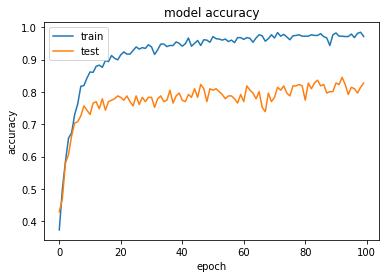

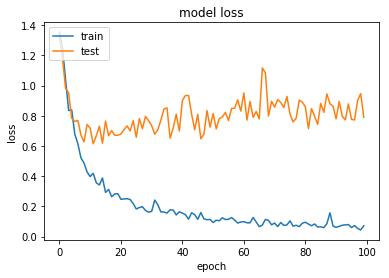

In [45]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
general_model.save('bert_relation_extraction')
#general_model = tf.keras.models.load_model('bert_relation_extraction')


In [47]:
from sklearn.metrics import classification_report
y_pred = general_model.predict(X_test_input, batch_size=32, verbose=10)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(y_test,y_pred_bool,target_names=['NoRelation','MinValue','MaxValue','IsValue']))

              precision    recall  f1-score   support

  NoRelation       0.77      0.84      0.80        58
    MinValue       0.79      0.68      0.73        40
    MaxValue       0.84      0.94      0.89        62
     IsValue       0.90      0.80      0.85        66

   micro avg       0.83      0.83      0.83       226
   macro avg       0.82      0.81      0.82       226
weighted avg       0.83      0.83      0.83       226

